## Questions:

- What to do with patients for whom NoDX is 'Dropped out before diagnosis was given' ??
- DX_{}_Cat : No Diagnosis Given: Incomplete Eval (what does this categeory mean?)
- For one patient (with id 716) there exists subcategory ADHD woth no appropriate category
- For some cases ACE_Score is not NaN although all scores ACE_{01-10} are NaN
- Some of the siorders presented in the original pdf are part of DX_Cat and some are part of DX_Sub 

In [9]:
import pandas as pd
import numpy as np

from os import listdir
from os.path import isfile, join

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

In [2]:
data = pd.read_csv('data/DataScience2019_MRI/Behavioral/AllData.csv', low_memory=False)

In [3]:
data

,Anonymized.ID,Subject.Type,Visit,Days.since.enrollment,EID,START_DATE,Patient_ID,Enrollment.Year,Enrollment.Season,Sex,...,YSR_TP,YSR_TP_T,YSR_Ext,YSR_Ext_T,YSR_Int,YSR_Int_T,YSR_OP,YSR_C,YSR_Total,YSR_Total_T
0,A00078864,UNKNOWN,V1,0,NDARYM832PX3,1901-01-01T07:00:00Z,NDARYM832PX3,2015,Spring,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A00078865,UNKNOWN,V1,0,NDARNJ687DMC,1901-01-01T07:00:00Z,NDARNJ687DMC,2015,Spring,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A00078866,UNKNOWN,V1,0,NDARRM363BXZ,1901-01-01T07:00:00Z,NDARRM363BXZ,2015,Spring,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A00078867,UNKNOWN,V1,0,NDARUW586LLL,1901-01-01T07:00:00Z,NDARUW586LLL,2015,Spring,1,...,15.0,75.0,16.0,60.0,29.0,68.0,8.0,40.0,85.0,68.0
4,A00078868,UNKNOWN,V1,0,NDARDC298NW4,1901-01-01T07:00:00Z,NDARDC298NW4,2015,Spring,0,...,9.0,67.0,10.0,52.0,26.0,72.0,11.0,34.0,70.0,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,A00093557,UNKNOWN,V1,0,NDARYZ986HEW,1901-01-01T07:00:00Z,NDARYZ986HEW,2018,Summer,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2092,A00093558,UNKNOWN,V1,0,NDARPM572ZZV,1901-01-01T07:00:00Z,NDARPM572ZZV,2018,Summer,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2093,A00093559,UNKNOWN,V1,0,NDARYA955CY1,1901-01-01T07:00:00Z,NDARYA955CY1,2018,Fall,0,...,6.0,60.0,11.0,53.0,13.0,59.0,3.0,23.0,47.0,58.0
2094,A00093560,UNKNOWN,V1,0,NDARRT283RHB,1901-01-01T07:00:00Z,NDARRT283RHB,2018,Fall,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
feat_to_drop = data.nunique() == 1
dropping_features = list(data.columns[feat_to_drop])

print('features to drop:', len(dropping_features))

features to drop: 289


In [18]:
data.drop(columns=dropping_features, inplace=True)

In [20]:
print('Total len of data', len(data))

data_nulls = data.isnull().apply(sum, axis=0).sort_values(ascending=False)

Total len of data 2096


In [27]:
# drop values for which more than threshold percent are NaNs
threshold = 0.8

dropped_columns = data_nulls.values > threshold * len(data)

In [4]:


np.sum(dropped_columns)

NameError: name 'dropped_columns' is not defined

In [32]:
data.drop(columns=data_nulls.index[dropped_columns], inplace=True)

In [45]:
all_dropped_features = list(data_nulls.index[dropped_columns].values) + dropping_features

len(all_dropped_features)

3042

In [33]:
data.columns

Index(['Anonymized.ID', 'EID', 'Patient_ID', 'Enrollment.Year',
       'Enrollment.Season', 'Sex', 'Age', 'Study.Site', 'Commercial.Use',
       'Release.Number',
       ...
       'YSR_TP', 'YSR_TP_T', 'YSR_Ext', 'YSR_Ext_T', 'YSR_Int', 'YSR_Int_T',
       'YSR_OP', 'YSR_C', 'YSR_Total', 'YSR_Total_T'],
      dtype='object', length=4000)

## Column observations

TODO: maybe theses observations may not be done on the initial dataset but on the reduced one based on the number of patients that actually have a diagnosis

In [6]:
whole_data = pd.read_csv('data/DataScience2019_MRI/Behavioral/AllData.csv', low_memory=False)

#### Diagnoses

In [308]:
disorders = set()

for i in range(1, 11):
    disorders.update(whole_data['DX_' + str(i).zfill(2) + '_Cat'].unique())
    
disorders = list(disorders)
disorders.remove(' ')
disorders = [x for x in disorders if str(x) != 'nan']

counter = np.zeros(len(disorders), dtype=np.int64)

for i in range(1, 11):
    test = whole_data['DX_' + str(i).zfill(2) + '_Cat'].values
    
    for j, disorder in enumerate(disorders):
        counter[j] += np.sum(test == disorder)

print(len(disorders))
for j, disorder in enumerate(disorders):
    print('{0: <60}: {1}'.format(disorder, counter[j]))

20
Other Conditions That May Be a Focus of Clinical Attention  : 23
Neurodevelopmental Disorders                                : 2081
No Diagnosis Given                                          : 235
Schizophrenia Spectrum and other Psychotic Disorders        : 10
Gender Dysphoria                                            : 1
Disruptive, Impulse Control and Conduct Disorders           : 35
Feeding and Eating Disorders                                : 10
Anxiety Disorders                                           : 597
Trauma and Stressor Related Disorders                       : 77
Sleep-Wake Disorders                                        : 3
No Diagnosis Given: Incomplete Eval                         : 278
Elimination Disorders                                       : 96
Substance Related and Addictive Disorders                   : 9
Apppendix (Neurobehavioral Disorder)                        : 1
Obsessive Compulsive and Related Disorders                  : 74
Neurocognitive Disord

In [310]:
disorders = set()

for i in range(1, 11):
    disorders.update(whole_data['DX_' + str(i).zfill(2) + '_Sub'].unique())
    
disorders = list(disorders)
disorders = [x for x in disorders if str(x) != 'nan']

counter = np.zeros(len(disorders), dtype=np.int64)

for i in range(1, 11):
    test = whole_data['DX_' + str(i).zfill(2) + '_Sub'].values
    
    for j, disorder in enumerate(disorders):
        counter[j] += np.sum(test == disorder)

print(len(disorders))
for j, disorder in enumerate(disorders):
    print('{0: <60}: {1}'.format(disorder, counter[j]))

17
Intellectual Disability                                     : 57
Tobacco-Related                                             : 2
Cannabis-Related                                            : 5
Motor Disorder                                              : 99
Abuse and Neglect: Child Maltreatment and Neglect Problems: Child Neglect: 1
Moderate                                                    : 1
Acute                                                       : 1
Specific Learning Disorder                                  : 366
Nonadherence to Medical Treatment                           : 16
Attention-Deficit/Hyperactivity Disorder                    : 1022
Past                                                        : 1
Communication Disorder                                      : 229
Other Neurodevelopmental Disorders                          : 3
Autism Spectrum Disorder                                    : 308
Problems Related to Other Psychosocial                      : 1
Alcohol-Rela

In [307]:
# ICD-10 codes are substantially more than the available disorders .. what does this mean ?

disorders = set()

for i in range(1, 11):
    disorders.update(whole_data['DX_' + str(i).zfill(2) + '_Code'].unique())
    
disorders = list(disorders)
disorders = [x for x in disorders if str(x) != 'nan']

counter = np.zeros(len(disorders), dtype=np.int64)

for i in range(1, 11):
    test = whole_data['DX_' + str(i).zfill(2) + '_Code'].values
    
    for j, disorder in enumerate(disorders):
        counter[j] += np.sum(test == disorder)

print(len(disorders))
for j, disorder in enumerate(disorders):
    print('{0: <60}: {1}'.format(disorder, counter[j]))

98
G47.00                                                      : 1
F71                                                         : 9
F28                                                         : 9
No Diagnosis Given                                          : 230
F20.9                                                       : 1
G47.09                                                      : 1
F80.9                                                       : 174
F31.89                                                      : 2
F32.0                                                       : 2
Z72.0                                                       : 2
F43.8                                                       : 11
F10.20                                                      : 1
F12.10                                                      : 3
F80.0                                                       : 28
F31.9                                                       : 2
F43.10                         

In [ ]:
# For all disorders the subcategory only exists when an category exists (sanity check)

test = pd.DataFrame()

for i in range(1, 11):
    whole_data['DX_' + str(i).zfill(2) + '_Cat'] = whole_data['DX_' + str(i).zfill(2) + '_Cat'].astype('str')
    whole_data['DX_' + str(i).zfill(2) + '_Sub'] = whole_data['DX_' + str(i).zfill(2) + '_Sub'].astype('str')
    mask = ((whole_data['DX_' + str(i).zfill(2) + '_Cat'] == 'nan').values & \
            (whole_data['DX_' + str(i).zfill(2) + '_Sub'] != 'nan').values)
        
    test = whole_data[mask][['DX_' + str(i).zfill(2) + '_Cat', 'DX_' + str(i).zfill(2) + '_Sub']]

test

In [297]:
# For one patient (with id 716) there exists subcategory ADHD woth no appropriate category

test = pd.DataFrame()

for i in range(1, 11):
    test = test.append(whole_data[(whole_data['DX_' + str(i).zfill(2) + '_Sub'] == 'Attention-Deficit/Hyperactivity Disorder') & \
                      (whole_data['DX_' + str(i).zfill(2) + '_Cat'] != 'Neurodevelopmental Disorders')]\
                       [['DX_' + str(i).zfill(2) + '_Cat', 'DX_' + str(i).zfill(2) + '_Sub']])
    

test

,DX_01_Cat,DX_01_Sub,DX_02_Cat,DX_02_Sub,DX_03_Cat,DX_03_Sub,DX_04_Cat,DX_04_Sub,DX_05_Cat,DX_05_Sub,DX_06_Cat,DX_06_Sub,DX_07_Cat,DX_07_Sub,DX_08_Cat,DX_08_Sub,DX_09_Cat,DX_09_Sub,DX_10_Cat,DX_10_Sub
716,No Diagnosis Given: Incomplete Eval,Attention-Deficit/Hyperactivity Disorder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# check the available data for each questionare


path = 'data/DataScience2019_MRI/Behavioral/description'
files = [f for f in listdir(path) if isfile(join(path, f))]

In [16]:
len(files)

104

In [80]:
# Assume that all same type questions are either filled all or none for each individual
# This is not always the case! See for example ACE!

total_rows = whole_data.shape[0]

filled_values_all_types = []

for file in files:
    column_type = file.split('.')[0]
    
    flag = 0
    for col in whole_data.columns:
        if column_type in col:
            flag = 1
            
            found = np.sum(~pd.isnull(whole_data[col]))
            
            filled_values = found / total_rows * 100
            filled_values_all_types.append(filled_values)
            
            print('---> For type {0: <12} a total of {1:6.4f} percent of values are filled'
                  .format(column_type, filled_values))
            
            break
            
    if flag == 0:
        print('---> For type {0: <12} not columns with the same name found.'.format(column_type))
        

---> For type DrugScreen   not columns with the same name found.
---> For type CGAS         a total of 53.8168 percent of values are filled
---> For type STAI         a total of 2.8626 percent of values are filled
---> For type PAQ_A        a total of 14.6947 percent of values are filled
---> For type PAQ_C        a total of 43.7977 percent of values are filled
---> For type CIS_P        a total of 58.8740 percent of values are filled
---> For type PreInt_Lang  not columns with the same name found.
---> For type YFAS_C       a total of 68.9885 percent of values are filled
---> For type PPVT         a total of 7.0611 percent of values are filled
---> For type EVT          a total of 7.0611 percent of values are filled
---> For type CELF         a total of 92.1756 percent of values are filled
---> For type Physical     not columns with the same name found.
---> For type ARI_S        a total of 88.7405 percent of values are filled
---> For type FGC          a total of 7.8721 percent of va

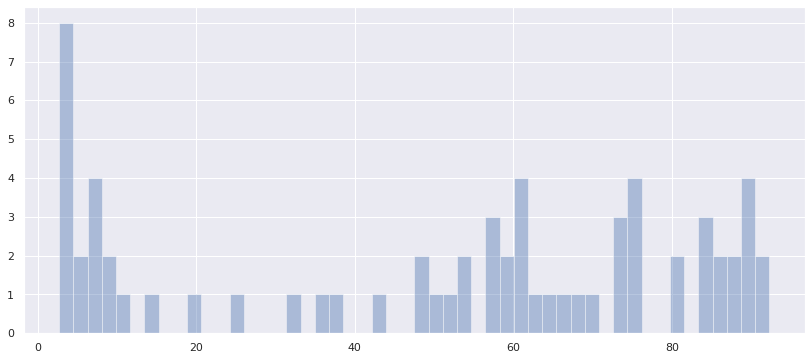

In [94]:
sns.set(color_codes=True)

sns.distplot(filled_values_all_types, kde=False, bins=50)

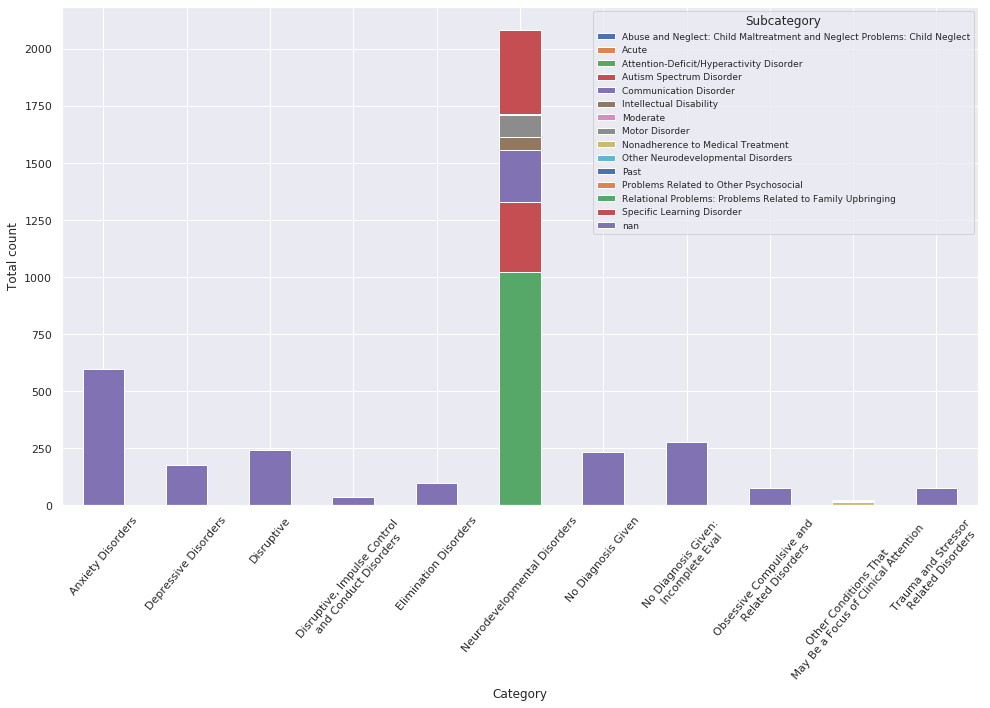

In [72]:
sns.set()

threshold = 20

for i in range(1, 11):
    if i == 1:
        categories = np.array(whole_data['DX_' + str(i).zfill(2) + '_Cat'].values, dtype=np.str)
        sub_categories = np.array(whole_data['DX_' + str(i).zfill(2) + '_Sub'].values, dtype=np.str)
    else:
        categories = np.concatenate((categories, 
                                     np.array(whole_data['DX_' + str(i).zfill(2) + '_Cat'].values, dtype=np.str)))
        sub_categories = np.concatenate((sub_categories,
                                     np.array(whole_data['DX_' + str(i).zfill(2) + '_Sub'].values, dtype=np.str)))


# remove nans
mask = ~(categories == 'nan')
categories = categories[mask]
sub_categories = sub_categories[mask]

# unique categories with less than threshold apearrences
unique, counts = np.unique(categories, return_counts=True)
valid_categories = unique[counts > threshold]

mask = [x in valid_categories for x in categories]
categories = categories[mask]
sub_categories = sub_categories[mask]

rcParams['figure.figsize'] = 14, 10
df = pd.DataFrame({'sub_categories': sub_categories, 'Category': categories})

for i in range(df.shape[0]):
    cat_ar = df.iloc[i]['Category'].split(" ")
    
    if len(cat_ar) > 3:
        df.iloc[i]['Category'] = " ".join(cat_ar[:3] + ["\n"] + cat_ar[3:])

ct = pd.crosstab(df.Category, df.sub_categories)

ct.plot.bar(stacked=True)
plt.legend(title='Subcategory', fontsize=9)
plt.xticks(rotation=50)
plt.ylabel('Total count')
plt.tight_layout()

plt.savefig('figures/cat_sub.png')

In [11]:
# barplot of diseases we are interested in 

most_common_disorders = ['Intellectual Disability', 'Obsessive Compulsive and Related Disorders', 
                         'Trauma and Stressor Related Disorders', 'Motor Disorder', 'Elimination Disorders',
                         'Depressive Disorders', 'Communication Disorder', 
                         'Disruptive, Impulse Control and Conduct Disorders',
                         'Autism Spectrum Disorder', 'Specific Learning Disorder',
                         'Anxiety Disorders', 'Attention-Deficit/Hyperactivity Disorder']

search_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)] + \
                 ['DX_' + str(i).zfill(2) + '_Sub' for i in range(1, 11)]

classes = np.zeros((len(most_common_disorders), whole_data.shape[0]))

data_classes = whole_data[search_columns]
patients_with_disorders = {}
first_diagnosis = []

for i, disorder in enumerate(most_common_disorders):
    mask = data_classes.select_dtypes(include=[object]). \
            applymap(lambda x: disorder in x if pd.notnull(x) else False)
    
    disorder_df = data_classes[mask.any(axis=1)]
    patients_with_disorders[disorder] = disorder_df.index.values
    
    first_diagnosis.append(
        np.sum((whole_data['DX_01_Cat'] == disorder) | (whole_data['DX_01_Sub'] == disorder).values))
    
    np.add.at(classes[i], disorder_df.index.values, 1)

Text(0.5, 0, 'totalCount')

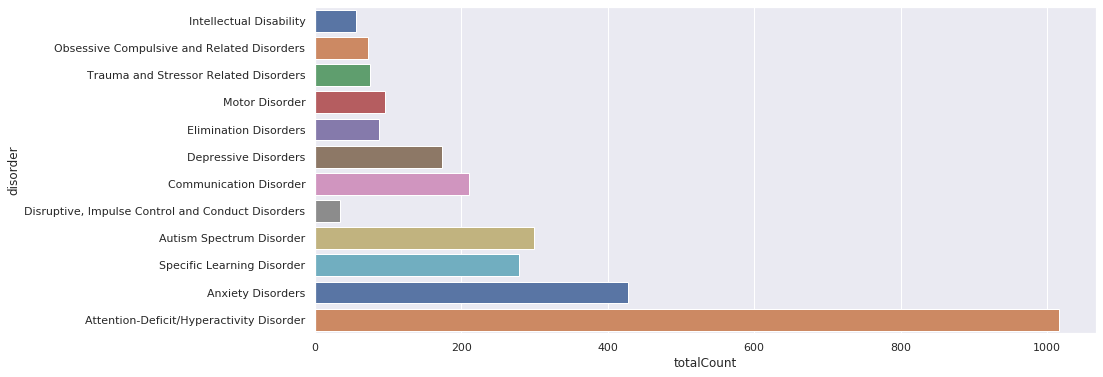

In [12]:
df = pd.DataFrame({'disorder': most_common_disorders, 'count': np.sum(classes, axis=1), 'first': first_diagnosis})

ax = sns.barplot(x='count', y='disorder', data=df, palette="deep")
ax.set_xlabel('totalCount')

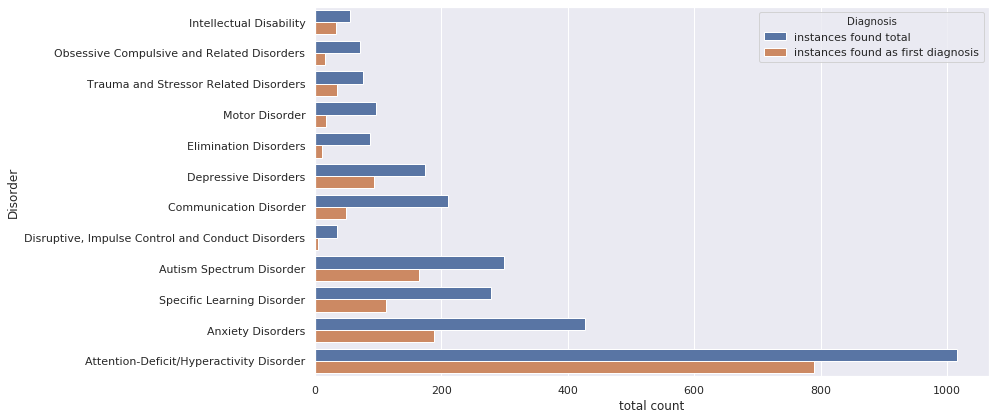

In [25]:
df = pd.DataFrame({'disorder': most_common_disorders, 
                   'instances found total': np.sum(classes, axis=1),
                   'instances found as first diagnosis': first_diagnosis})

tidy = df.melt(id_vars='disorder').rename(columns=str.title)
tidy = tidy.rename(columns={"Variable": "Diagnosis"})

ax = sns.barplot(x='Value', y='Disorder', hue='Diagnosis', data=tidy, palette="deep")
ax.set_xlabel('total count')

plt.tight_layout()
plt.savefig('figures/diagnosis.png')

In [41]:
score_columns = []

for col in whole_data.columns:
    if 'score' in col.lower():
        score_columns.append(col)

In [45]:
completed_surveys = []

for disorder in most_common_disorders:
    relevant_patients = patients_with_disorders[disorder]

    t = whole_data.iloc[relevant_patients][score_columns].isna().sum().sort_values(kind='mergesort')
    
    total_surveys = len(relevant_patients) * len(score_columns)
    
    percentage_of_completed_surveys = (total_surveys -  np.sum(t)) / total_surveys * 100
    completed_surveys.append(percentage_of_completed_surveys)

Text(0.5, 0, 'percentage')

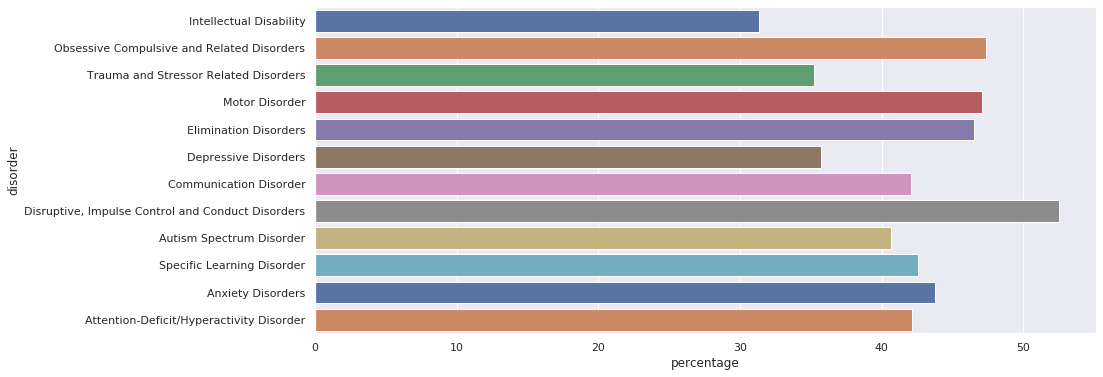

In [293]:
df = pd.DataFrame({'disorder': most_common_disorders, 'completed_surveys': completed_surveys})

ax = sns.barplot(x='completed_surveys', y='disorder', data=df, palette="deep")
ax.set_xlabel('percentage')

In [109]:
# For some cases ACE_Score is not NaN although all scores ACE_{01-10} are NaN
# Also should we care about all the ACE random columns?

positions = list(set(whole_data[~ np.isnan(whole_data['ACE_Score'])].index) - \
                    set(whole_data[~ np.isnan(whole_data['ACE_01'])].index))

print(positions)

relevant_columns = ['ACE_0' + str(i) for i in range(1, 10)] + ['ACE_10', 'ACE_Score']
whole_data[relevant_columns].iloc[positions]

[2072, 1996, 1956]


,ACE_01,ACE_02,ACE_03,ACE_04,ACE_05,ACE_06,ACE_07,ACE_08,ACE_09,ACE_10,ACE_Score
2072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [122]:
# Percentage of NaN values for APQ_P
# for all columns the same values are Nan

cols = ['APQ_P_' + i for i in ['INV', 'PP', 'PM', 'ID', 'CP', 'Total', 'OPD']]
print('For the columns:', cols)

print('This percentage of values are Nan:', np.sum(np.isnan(whole_data[cols[0]].values)) / len(whole_data))

For the columns: ['APQ_P_INV', 'APQ_P_PP', 'APQ_P_PM', 'APQ_P_ID', 'APQ_P_CP', 'APQ_P_Total', 'APQ_P_OPD']
This percentage of values are Nan: 0.15314885496183206


In [127]:
# Percentage of NaN values for APQ_SR
# for all columns the same values are Nan

cols = ['APQ_SR_' + i for i in ['INV_D', 'INV_M', 'PP', 'PM', 'CP', 'OPD', 'Total']]
print('For the columns:', cols)

print('This percentage of values are Nan:', np.sum(np.isnan(whole_data[cols[0]].values)) / len(whole_data))

For the columns: ['APQ_SR_INV_D', 'APQ_SR_INV_M', 'APQ_SR_PP', 'APQ_SR_PM', 'APQ_SR_CP', 'APQ_SR_OPD', 'APQ_SR_Total']
This percentage of values are Nan: 0.16173664122137404


In [136]:
# Percentage of NaN values for ARI_P

cols = ['ARI_P_0' + str(i) for i in range(1, 8)] + ['ARI_P_Total_Score']
print('For the columns:', cols)

for col in cols:
    print('This percentage of values are Nan:', np.sum(np.isnan(whole_data[col].values)) / len(whole_data))

For the columns: ['ARI_P_01', 'ARI_P_02', 'ARI_P_03', 'ARI_P_04', 'ARI_P_05', 'ARI_P_06', 'ARI_P_07', 'ARI_P_Total_Score']
This percentage of values are Nan: 0.1340648854961832
This percentage of values are Nan: 0.13454198473282442
This percentage of values are Nan: 0.1340648854961832
This percentage of values are Nan: 0.13454198473282442
This percentage of values are Nan: 0.1340648854961832
This percentage of values are Nan: 0.13549618320610687
This percentage of values are Nan: 0.13454198473282442
This percentage of values are Nan: 0.1340648854961832


In [137]:
# Percentage of NaN values for ARI_S

cols = ['ARI_S_0' + str(i) for i in range(1, 8)] + ['ARI_P_Total_Score']
print('For the columns:', cols)

for col in cols:
    print('This percentage of values are Nan:', np.sum(np.isnan(whole_data[col].values)) / len(whole_data))

For the columns: ['ARI_S_01', 'ARI_S_02', 'ARI_S_03', 'ARI_S_04', 'ARI_S_05', 'ARI_S_06', 'ARI_S_07', 'ARI_P_Total_Score']
This percentage of values are Nan: 0.11259541984732824
This percentage of values are Nan: 0.11307251908396947
This percentage of values are Nan: 0.11402671755725191
This percentage of values are Nan: 0.11259541984732824
This percentage of values are Nan: 0.11307251908396947
This percentage of values are Nan: 0.11307251908396947
This percentage of values are Nan: 0.11354961832061068
This percentage of values are Nan: 0.1340648854961832


## test

## Simple algorithm

In [364]:
data = pd.read_csv('data/DataScience2019_MRI/Behavioral/AllData.csv', low_memory=False)

# For start only keep patients for which we have actual diagnosis
# not having a diagnosis means that they are healthy ?
data = data[(data['NoDX'] == 'Yes') | (data['NoDX'] == 'No')]
data.reset_index(inplace=True)

important_columns = ['Sex', 'Age', 'BMI', 'Handedness', 'WISC_FSIQ']

In [365]:
data['Handedness'].fillna(0, inplace=True)

In [366]:
data['BMI'].fillna((data['BMI'].mean()), inplace=True)

In [367]:
data['WISC_FSIQ'].fillna((data['WISC_FSIQ'].mean()), inplace=True)

In [368]:
most_common_disorders = ['Intellectual Disability', 'Obsessive Compulsive and Related Disorders', 
                         'Trauma and Stressor Related Disorders', 'Motor Disorder', 'Elimination Disorders',
                         'Depressive Disorders', 'Communication Disorder', 
                         'Disruptive, Impulse Control and Conduct Disorders',
                         'Autism Spectrum Disorder', 'Specific Learning Disorder',
                         'Anxiety Disorders', 'Attention-Deficit/Hyperactivity Disorder']

search_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)] + \
                 ['DX_' + str(i).zfill(2) + '_Sub' for i in range(1, 11)]

In [372]:
classes = np.zeros((len(most_common_disorders), data.shape[0]))

data_classes = data[search_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = data_classes.select_dtypes(include=[object]). \
            applymap(lambda x: disorder in x if pd.notnull(x) else False)
    
    disorder_df = data_classes[mask.any(axis=1)]
    
    np.add.at(classes[i], disorder_df.index.values, 1)
    
    # same as np.sum(classes[i])
    print('{0: <50}: {1}'.format(disorder, disorder_df.shape[0]))

Intellectual Disability                           : 56
Obsessive Compulsive and Related Disorders        : 72
Trauma and Stressor Related Disorders             : 76
Motor Disorder                                    : 96
Elimination Disorders                             : 88
Depressive Disorders                              : 174
Communication Disorder                            : 210
Disruptive, Impulse Control and Conduct Disorders : 35
Autism Spectrum Disorder                          : 299
Specific Learning Disorder                        : 279
Anxiety Disorders                                 : 427
Attention-Deficit/Hyperactivity Disorder          : 1015


In [375]:
data = data[important_columns]

In [378]:
from sklearn.ensemble import RandomForestClassifier



In [380]:
from sklearn.model_selection import train_test_split

In [401]:
X_train, X_test, y_train, y_test = train_test_split(data, classes[-1], test_size=0.25, random_state=42)

In [402]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1360, 5)
(454, 5)
(1360,)
(454,)


In [403]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced')

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [404]:
preds = clf.predict(X_test)

In [405]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print('accuracy', accuracy_score(y_test, preds))

print(confusion_matrix(y_test, preds))

print(classification_report(y_test, preds))

accuracy 0.5969162995594713
[[ 96  98]
 [ 85 175]]
              precision    recall  f1-score   support

         0.0       0.53      0.49      0.51       194
         1.0       0.64      0.67      0.66       260

    accuracy                           0.60       454
   macro avg       0.59      0.58      0.58       454
weighted avg       0.59      0.60      0.59       454

